In [1]:
import pycuda.driver as cuda
import pycuda.autoinit

print("CUDA device name:", cuda.Device(0).name())
print("hereee")

CUDA device name: NVIDIA GeForce GTX 1650
hereee


In [ ]:
import numpy as np
import pickle
import json
import time
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit
import networkx as nx
from pathlib import Path
import os


def print_gpu_info():
    device = cuda.Device(0)  
    print("GPU Information:")
    print(f"  Name: {device.name()}")
    print(f"  Compute Capability: {device.compute_capability()}")
    print(f"  Total Memory: {device.total_memory() / 1e9:.2f} GB")


def load_graphs(graph_dir, graph_indices=None):
    graphs = []
    indices_filter = "*" if graph_indices is None else f"[{graph_indices}]"
    for graph_file in Path(graph_dir).glob(f"graph_{indices_filter}.pkl"):
        with open(graph_file, "rb") as f:
            graph_data = pickle.load(f)
            graphs.append(graph_data)
            print(f"Loaded graph: {graph_file}")
    return graphs

# Matrix multiplication method for dense matrices (one thread per output cell)
def dense_matrix_multiply_pycuda(A, B):
    A_dense = A.astype(np.float32)
    B_dense = B.astype(np.float32)

    rows_A, cols_A = A_dense.shape
    rows_B, cols_B = B_dense.shape

    if cols_A != rows_B:
        raise ValueError("Matrix dimensions do not match for multiplication")

    A_gpu = cuda.mem_alloc(A_dense.nbytes)
    B_gpu = cuda.mem_alloc(B_dense.nbytes)
    C_gpu = cuda.mem_alloc(rows_A * cols_B * A_dense.dtype.itemsize)

    cuda.memcpy_htod(A_gpu, A_dense)
    cuda.memcpy_htod(B_gpu, B_dense)

    mod = SourceModule(
        """
        __global__ void matmul(float *A, float *B, float *C, int rowsA, int colsA, int colsB) {
            int row = blockIdx.y * blockDim.y + threadIdx.y;
            int col = blockIdx.x * blockDim.x + threadIdx.x;
            
            if (row < rowsA && col < colsB) {
                float sum = 0.0f;
                for (int k = 0; k < colsA; ++k) {
                    sum += A[row * colsA + k] * B[k * colsB + col];
                }
                C[row * colsB + col] = sum;
            }
        }
        """
    )

    matmul = mod.get_function("matmul")
    block_size = (16, 16, 1)
    grid_size = (
        int(np.ceil(cols_B / 16)),
        int(np.ceil(rows_A / 16)),
        1,
    )
    matmul(
        A_gpu, B_gpu, C_gpu,
        np.int32(rows_A), np.int32(cols_A), np.int32(cols_B),
        block=block_size, grid=grid_size
    )

    C_dense = np.empty((rows_A, cols_B), dtype=np.float32)
    cuda.memcpy_dtoh(C_dense, C_gpu)

    return C_dense


def gpu_warmup():
    dummy_A = np.ones((16, 16), dtype=np.float32)
    dummy_B = np.ones((16, 16), dtype=np.float32)
    print("Warming up GPU...")
    for _ in range(2):  # Run the warmup twice
        dense_matrix_multiply_pycuda(dummy_A, dummy_B)
    print("GPU warmup complete.")

# Run tests and collect results
def process_graphs(graphs):
    results = []
    for graph_info in graphs:
        index = graph_info["index"]
        name = graph_info["name"]
        graph_type = graph_info["type"]
        graph = graph_info["graph"]
        feature_matrix = graph_info["feature_matrix"]
        num_nodes = graph_info["num_nodes"]
        sparsity = graph_info["sparsity"]
        print(f"Testing graph {index}")

        # Build dense adjacency matrix
        adjacency_matrix = nx.to_numpy_array(graph, dtype=np.float32)

        # Perform multiplication with feature matrix
        start_time = time.time()
        aggregated_feature_matrix = dense_matrix_multiply_pycuda(adjacency_matrix, feature_matrix)
        end_time = time.time()

        elapsed_time = end_time - start_time
        results.append(
            {
                "graph_index": index,
                "graph_name": name,
                "graph_type": graph_type,
                "method": "pycuda_dense",
                "time_seconds": elapsed_time,
                "date": time.strftime("%Y-%m-%d %H:%M:%S"),
                "num_nodes": num_nodes,
                "sparsity": sparsity,
            }
        )
    return results

# Load or update results
def update_results(results, result_file="gnn_results1.json"):

    # Load existing results or create a new list
    if os.path.exists(result_file):
        with open(result_file, "r") as f:
            try:
                all_results = json.load(f)
            except json.JSONDecodeError:
                all_results = []
    else:
        all_results = []

    # Update results by replacing existing ones by graph index and method
    for result in results:
        all_results = [
            r
            for r in all_results
            if not (r["graph_index"] == result["graph_index"] and r["method"] == result["method"])
        ]
        all_results.append(result)

    # Save updated results
    with open(result_file, "w") as f:
        json.dump(all_results, f, indent=4)

    print(f"Results have been saved to '{result_file}'.")


print_gpu_info() 
graph_dir = r"C:\Users\joyji\Documents\GitHub\gpugnn\graphs"
graph_indices = None  

# Load graphs
graphs = load_graphs(graph_dir, graph_indices)
if not graphs:
    print("No graphs found to process.")
else:
    # GPU warmup
    gpu_warmup()

    # Process graphs
    results = process_graphs(graphs)

    # Update and save results
    update_results(results)

    # Print results
    print(json.dumps(results, indent=4))


GPU Information:
  Name: NVIDIA GeForce GTX 1650
  Compute Capability: (7, 5)
  Total Memory: 4.29 GB
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_0.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_1.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_10.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_11.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_12.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_13.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_14.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_15.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_16.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_17.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_18.pkl
Loaded graph: C:\Users\joyji\Documents\GitHub\gpugnn\graphs\graph_19.pkl
Loaded graph: C:\Users\j

C:\Users\joyji\AppData\Local\Temp\ipykernel_13264\863701910.py:49: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  mod = SourceModule(


GPU warmup complete.
Testing graph 0


AttributeError: 'csr_matrix' object has no attribute 'nbytes'

In [6]:
import pickle
from pathlib import Path

import networkx as nx
import numpy as np


In [7]:
def generate_synthetic_graphs(num_graphs, num_nodes_list, sparsity_levels, gen_type="both"):
    graphs = []
    if gen_type == "both" or gen_type == "erdos-renyi":
        for num_nodes in num_nodes_list:
            for p in sparsity_levels:
                for i in range(num_graphs):
                    G_er = nx.gnp_random_graph(num_nodes, p, directed=False)
                    node_mapping = {node: idx for idx, node in enumerate(G_er.nodes())}
                    G_er = nx.relabel_nodes(G_er, node_mapping)
                    graphs.append({
                        "graph": G_er,
                        "name": f"Erdos-Renyi_{num_nodes}_p_{p}_graph_{i+1}",
                        "type": "synthetic",
                        "num_nodes": G_er.number_of_nodes(),
                        "sparsity": p,
                    })
    if gen_type == "both" or gen_type == "scale-free":
        for num_nodes in num_nodes_list:
            for i in range(num_graphs):
                G_sf = nx.barabasi_albert_graph(num_nodes, m=5)
                node_mapping = {node: idx for idx, node in enumerate(G_sf.nodes())}
                G_sf = nx.relabel_nodes(G_sf, node_mapping)
                graphs.append({
                    "graph": G_sf,
                    "name": f"Scale-Free_{num_nodes}_graph_{i+1}",
                    "type": "synthetic",
                    "num_nodes": G_sf.number_of_nodes(),
                    "sparsity": None,
                })
    return graphs


In [8]:
def generate_feature_matrices(graphs, num_features=10):
    for graph_data in graphs:
        num_nodes = graph_data["graph"].number_of_nodes()
        feature_matrix = np.random.rand(num_nodes, num_features).astype(np.float32)
        graph_data["feature_matrix"] = feature_matrix
    return graphs


In [9]:
def save_graphs(graphs, output_dir="graphs2"):
    graph_dir = Path(output_dir)
    graph_dir.mkdir(exist_ok=True)
    for index, graph in enumerate(graphs):
        with open(graph_dir / f"graph_{index}.pkl", "wb") as f:
            pickle.dump({
                "index": index,
                "name": graph["name"],
                "type": graph["type"],
                "graph": graph["graph"],
                "feature_matrix": graph["feature_matrix"],
                "num_nodes": graph["num_nodes"],
                "sparsity": graph["sparsity"],
            }, f)
    print(f"Saved {len(graphs)} graphs to '{output_dir}' directory.")


In [10]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters for graph generation
num_graphs = 1
num_nodes_list = [1000, 2000, 3000]
sparsity_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9]
number_of_features = 10
g_type = "both"

# Generate all graphs
graphs = generate_synthetic_graphs(num_graphs, num_nodes_list, sparsity_levels, gen_type=g_type)

# Generate feature matrices
graphs = generate_feature_matrices(graphs, number_of_features)

# Save the graphs
save_graphs(graphs)

print(f"Generated and saved {len(graphs)} graphs with metadata and feature matrices.")


KeyboardInterrupt: 

In [14]:
import pickle
from pathlib import Path
import shutil
import networkx as nx
import numpy as np


# Log utility function
def log(message):
    print(f"[LOG]: {message}")


# Function to clear the graphs directory
def clear_directory(directory):
    dir_path = Path(directory)
    if dir_path.exists():
        shutil.rmtree(dir_path)  # Deletes the directory and its contents
    dir_path.mkdir()  # Creates a new empty directory
    log(f"Cleared and created directory: {directory}")


# Generate synthetic graphs (Erdős-Rényi and Scale-Free)
def generate_synthetic_graphs(num_graphs, num_nodes_list, sparsity_levels, gen_type="both"):
    """
    Generate a list of synthetic graphs with varying sizes and sparsity levels.

    Parameters:
    num_graphs (int): Number of graphs per combination of size and sparsity.
    num_nodes_list (list): List of graph sizes (number of nodes).
    sparsity_levels (list): List of sparsity levels (between 0 and 1).

    Returns:
    list: List of NetworkX graph objects.
    """
    graphs = []
    log("Starting synthetic graph generation...")

    if gen_type == "both" or gen_type == "erdos-renyi":
        log("Generating Erdős-Rényi graphs...")
        for num_nodes in num_nodes_list:
            for p in sparsity_levels:
                for i in range(num_graphs):
                    G_er = nx.gnp_random_graph(num_nodes, p, directed=False)
                    node_mapping = {node: idx for idx, node in enumerate(G_er.nodes())}
                    G_er = nx.relabel_nodes(G_er, node_mapping)
                    graphs.append({
                        "graph": G_er,
                        "name": f"Erdos-Renyi_{num_nodes}_p_{p}_graph_{i+1}",
                        "type": "synthetic",
                        "num_nodes": G_er.number_of_nodes(),
                        "sparsity": p,
                    })
        log("Erdős-Rényi graphs generated successfully!")

    if gen_type == "both" or gen_type == "scale-free":
        log("Generating Scale-Free graphs...")
        for num_nodes in num_nodes_list:
            for i in range(num_graphs):
                G_sf = nx.barabasi_albert_graph(num_nodes, m=5)
                node_mapping = {node: idx for idx, node in enumerate(G_sf.nodes())}
                G_sf = nx.relabel_nodes(G_sf, node_mapping)
                graphs.append({
                    "graph": G_sf,
                    "name": f"Scale-Free_{num_nodes}_graph_{i+1}",
                    "type": "synthetic",
                    "num_nodes": G_sf.number_of_nodes(),
                    "sparsity": None,
                })
        log("Scale-Free graphs generated successfully!")

    return graphs


# Generate feature matrices for each graph
def generate_feature_matrices(graphs, num_features=10):
    """
    Generate a feature matrix for each graph and add it to the graph metadata.

    Parameters:
    graphs (list): List of graph metadata dictionaries.
    num_features (int): Number of features per node.

    Returns:
    list: List of graphs with feature matrices added.
    """
    log("Generating feature matrices for each graph...")
    for graph_data in graphs:
        num_nodes = graph_data["graph"].number_of_nodes()
        feature_matrix = np.random.rand(num_nodes, num_features).astype(np.float32)
        graph_data["feature_matrix"] = feature_matrix
    log("Feature matrices generated successfully!")
    return graphs


# Save graphs to file
def save_graphs(graphs, output_dir="graphs2"):
    """
    Save the generated graphs to the specified directory.

    Parameters:
    graphs (list): List of graphs to save.
    """
    log(f"Saving graphs to '{output_dir}' directory...")
    graph_dir = Path(output_dir)
    for index, graph in enumerate(graphs):
        with open(graph_dir / f"graph_{index}.pkl", "wb") as f:
            pickle.dump({
                "index": index,
                "name": graph["name"],
                "type": graph["type"],
                "graph": graph["graph"],
                "feature_matrix": graph["feature_matrix"],
                "num_nodes": graph["num_nodes"],
                "sparsity": graph["sparsity"],
            }, f)
    log(f"Saved {len(graphs)} graphs successfully!")


# Main execution block
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Parameters for graph generation
    num_graphs = 1
    num_nodes_list = [1000, 2000, 3000]
    sparsity_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9]
    number_of_features = 10
    g_type = "both"
    output_directory = "D:\GaganData\graphs2"

    # Clear and create output directory
    clear_directory(output_directory)

    # Generate all graphs
    log("Starting the graph generation process...")
    graphs = generate_synthetic_graphs(num_graphs, num_nodes_list, sparsity_levels, gen_type=g_type)

    # Generate feature matrices
    graphs = generate_feature_matrices(graphs, number_of_features)

    # Save the graphs
    save_graphs(graphs, output_directory)

    # Print final confirmation
    log(f"Generated and saved {len(graphs)} graphs with metadata and feature matrices.")


[LOG]: Cleared and created directory: D:\GaganData\graphs2
[LOG]: Starting the graph generation process...
[LOG]: Starting synthetic graph generation...
[LOG]: Generating Erdős-Rényi graphs...
[LOG]: Erdős-Rényi graphs generated successfully!
[LOG]: Generating Scale-Free graphs...
[LOG]: Scale-Free graphs generated successfully!
[LOG]: Generating feature matrices for each graph...
[LOG]: Feature matrices generated successfully!
[LOG]: Saving graphs to 'D:\GaganData\graphs2' directory...
[LOG]: Saved 24 graphs successfully!
[LOG]: Generated and saved 24 graphs with metadata and feature matrices.


Loading graph file: D:\GaganData\graphs2\graph_0.pkl
Graph Metadata:
Name: Erdos-Renyi_1000_p_0.01_graph_1
Type: synthetic
Number of Nodes: 1000
Sparsity: 0.01
Feature Matrix Shape: (1000, 10)
Feature Matrix Type: <class 'numpy.ndarray'>


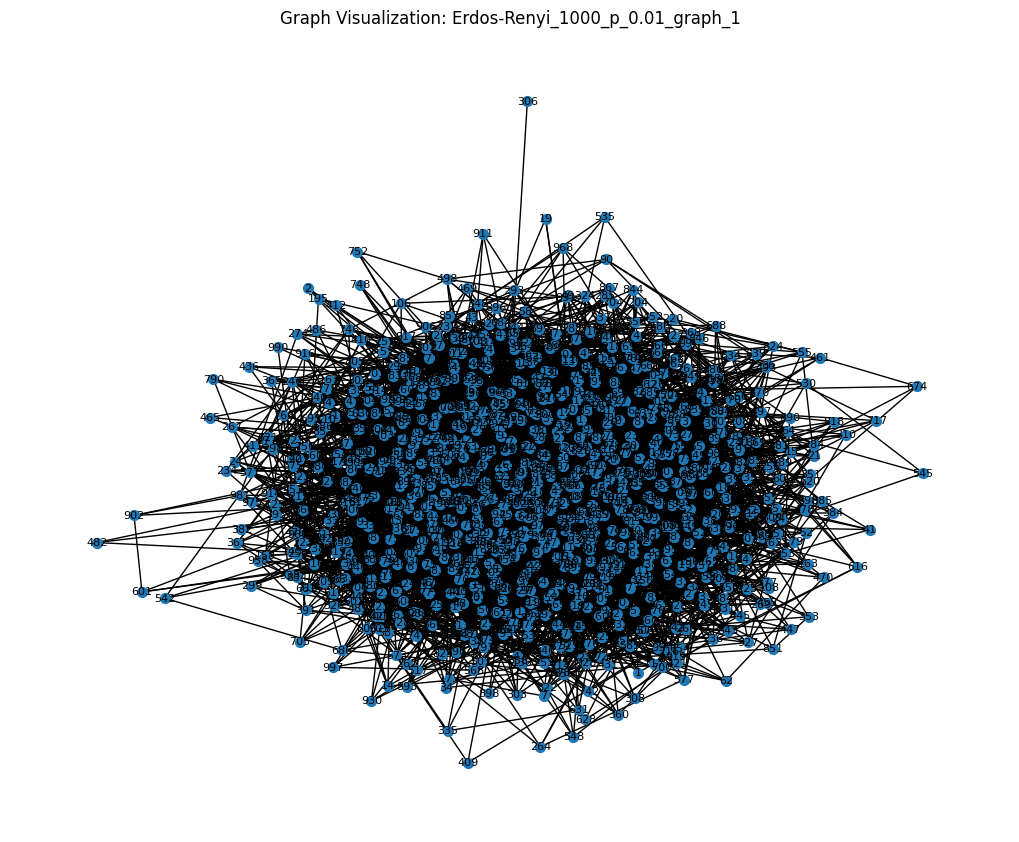

In [3]:
import pickle
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

# Path to the graphs directory
graphs_dir = Path("D:\GaganData\graphs2")

# List all saved graph files
graph_files = list(graphs_dir.glob("graph_*.pkl"))

if not graph_files:
    print(f"No graph files found in directory: {graphs_dir}")
else:
    # Load the first graph file
    graph_file = graph_files[0]
    print(f"Loading graph file: {graph_file}")

    with open(graph_file, "rb") as f:
        graph_data = pickle.load(f)

    # Print graph metadata
    print("Graph Metadata:")
    print(f"Name: {graph_data['name']}")
    print(f"Type: {graph_data['type']}")
    print(f"Number of Nodes: {graph_data['num_nodes']}")
    print(f"Sparsity: {graph_data['sparsity']}")

    # Display the feature matrix shape and type
    feature_matrix = graph_data["feature_matrix"]
    print(f"Feature Matrix Shape: {feature_matrix.shape}")
    print(f"Feature Matrix Type: {type(feature_matrix)}")

    # Draw the graph using NetworkX and Matplotlib
    graph = graph_data["graph"]
    plt.figure(figsize=(10, 8))
    nx.draw(graph, with_labels=True, node_size=50, font_size=8)
    plt.title(f"Graph Visualization: {graph_data['name']}")
    plt.show()


In [4]:
import pickle
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

# Path to the graphs directory
graphs_dir = Path(r"D:\GaganData\graphs2")

# List all saved graph files
graph_files = list(graphs_dir.glob("graph_*.pkl"))

if not graph_files:
    print(f"No graph files found in directory: {graphs_dir}")
else:
    print(f"Found {len(graph_files)} graph files. Filtering graphs with sparsity 0.8...\n")
    for graph_file in graph_files:
        with open(graph_file, "rb") as f:
            graph_data = pickle.load(f)

        # Check if the graph has the required sparsity
        if graph_data.get("sparsity") == 0.8:
            print(f"Loading graph file: {graph_file}")
            
            # Print graph metadata
            print("Graph Metadata:")
            print(f"Name: {graph_data['name']}")
            print(f"Type: {graph_data['type']}")
            print(f"Number of Nodes: {graph_data['num_nodes']}")
            print(f"Sparsity: {graph_data['sparsity']}")

            # Display the feature matrix shape and type
            feature_matrix = graph_data["feature_matrix"]
            print(f"Feature Matrix Shape: {feature_matrix.shape}")
            print(f"Feature Matrix Type: {type(feature_matrix)}\n")

            # Draw the graph using NetworkX and Matplotlib
            graph = graph_data["graph"]
            plt.figure(figsize=(10, 8))
            nx.draw(graph, with_labels=True, node_size=50, font_size=8)
            plt.title(f"Graph Visualization: {graph_data['name']}")
            plt.show()


Found 24 graph files. Filtering graphs with sparsity 0.8...

Loading graph file: D:\GaganData\graphs2\graph_12.pkl
Graph Metadata:
Name: Erdos-Renyi_2000_p_0.8_graph_1
Type: synthetic
Number of Nodes: 2000
Sparsity: 0.8
Feature Matrix Shape: (2000, 10)
Feature Matrix Type: <class 'numpy.ndarray'>



KeyboardInterrupt: 

Found 24 graph files. Filtering graphs with 1000 nodes and sparsity 0.8...

Loading graph file: D:\GaganData\graphs2\graph_5.pkl
Graph Metadata:
Name: Erdos-Renyi_1000_p_0.8_graph_1
Type: synthetic
Number of Nodes: 1000
Sparsity: 0.8
Feature Matrix Shape: (1000, 10)
Feature Matrix Type: <class 'numpy.ndarray'>



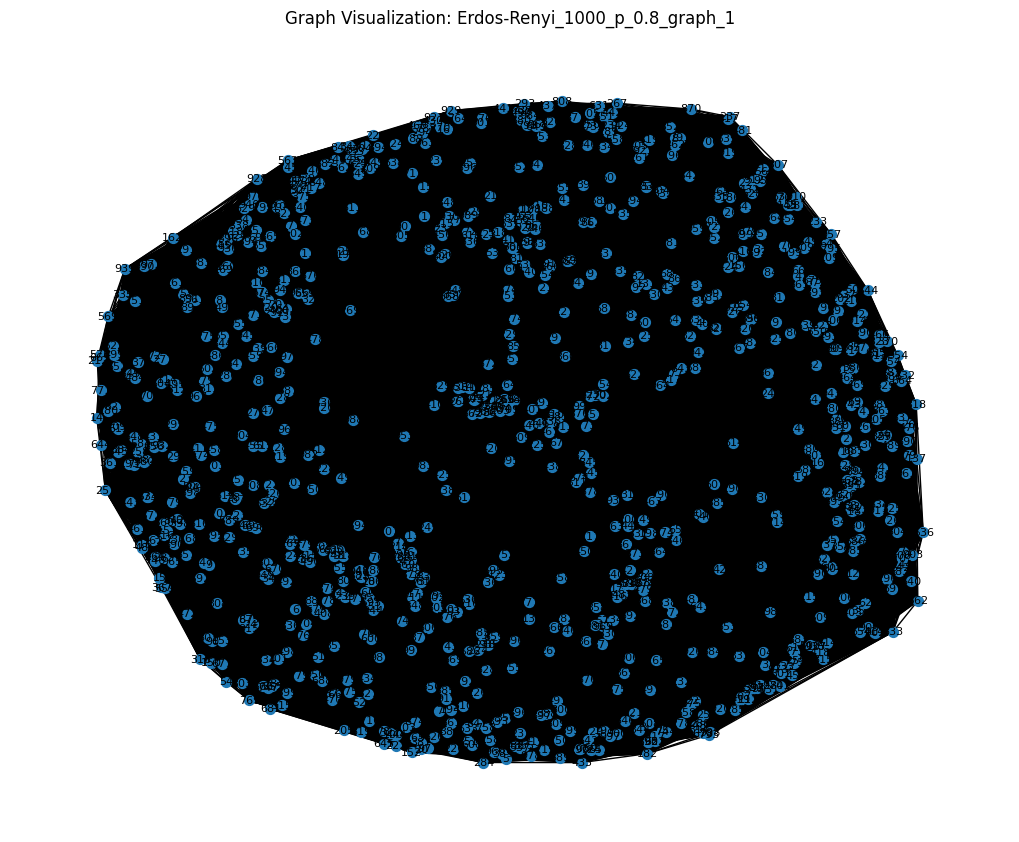

In [5]:
#Inlcude in Repo

import pickle
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

# Path to the graphs directory
graphs_dir = Path(r"D:\GaganData\graphs2")

# List all saved graph files
graph_files = list(graphs_dir.glob("graph_*.pkl"))

if not graph_files:
    print(f"No graph files found in directory: {graphs_dir}")
else:
    print(f"Found {len(graph_files)} graph files. Filtering graphs with 1000 nodes and sparsity 0.8...\n")
    for graph_file in graph_files:
        with open(graph_file, "rb") as f:
            graph_data = pickle.load(f)

        # Check if the graph has the required number of nodes and sparsity
        if graph_data.get("num_nodes") == 1000 and graph_data.get("sparsity") == 0.8:
            print(f"Loading graph file: {graph_file}")
            
            # Print graph metadata
            print("Graph Metadata:")
            print(f"Name: {graph_data['name']}")
            print(f"Type: {graph_data['type']}")
            print(f"Number of Nodes: {graph_data['num_nodes']}")
            print(f"Sparsity: {graph_data['sparsity']}")

            # Display the feature matrix shape and type
            feature_matrix = graph_data["feature_matrix"]
            print(f"Feature Matrix Shape: {feature_matrix.shape}")
            print(f"Feature Matrix Type: {type(feature_matrix)}\n")

            # Draw the graph using NetworkX and Matplotlib
            graph = graph_data["graph"]
            plt.figure(figsize=(10, 8))
            nx.draw(graph, with_labels=True, node_size=50, font_size=8)
            plt.title(f"Graph Visualization: {graph_data['name']}")
            plt.show()


In [10]:
#Inlcude in Repo

import numpy as np
import pickle
import json
import time
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit
import networkx as nx
from pathlib import Path
import os

# Function to print GPU information
def print_gpu_info():
    device = cuda.Device(0)  # Assuming GPU 0 is being used
    print("GPU Information:")
    print(f"  Name: {device.name()}")
    print(f"  Compute Capability: {device.compute_capability()}")
    print(f"  Total Memory: {device.total_memory() / 1e9:.2f} GB")

# Function to load graphs from a directory
def load_graphs(graph_dir, graph_indices=None):
    graphs = []
    indices_filter = "*" if graph_indices is None else f"[{graph_indices}]"
    for graph_file in Path(graph_dir).glob(f"graph_{indices_filter}.pkl"):
        with open(graph_file, "rb") as f:
            graph_data = pickle.load(f)
            graphs.append(graph_data)
            print(f"Loaded graph: {graph_file}")
    return graphs

# Matrix multiplication method for dense matrices (one thread per output cell)
def dense_matrix_multiply_pycuda(A, B):
    A_dense = A.astype(np.float32)
    B_dense = B.astype(np.float32)

    rows_A, cols_A = A_dense.shape
    rows_B, cols_B = B_dense.shape

    if cols_A != rows_B:
        raise ValueError("Matrix dimensions do not match for multiplication")

    A_gpu = cuda.mem_alloc(A_dense.nbytes)
    B_gpu = cuda.mem_alloc(B_dense.nbytes)
    C_gpu = cuda.mem_alloc(rows_A * cols_B * A_dense.dtype.itemsize)

    cuda.memcpy_htod(A_gpu, A_dense)
    cuda.memcpy_htod(B_gpu, B_dense)

    mod = SourceModule(
        """
        __global__ void matmul(float *A, float *B, float *C, int rowsA, int colsA, int colsB) {
            int row = blockIdx.y * blockDim.y + threadIdx.y;
            int col = blockIdx.x * blockDim.x + threadIdx.x;
            
            if (row < rowsA && col < colsB) {
                float sum = 0.0f;
                for (int k = 0; k < colsA; ++k) {
                    sum += A[row * colsA + k] * B[k * colsB + col];
                }
                C[row * colsB + col] = sum;
            }
        }
        """
    )

    matmul = mod.get_function("matmul")
    block_size = (16, 16, 1)
    grid_size = (
        int(np.ceil(cols_B / 16)),
        int(np.ceil(rows_A / 16)),
        1,
    )
    matmul(
        A_gpu, B_gpu, C_gpu,
        np.int32(rows_A), np.int32(cols_A), np.int32(cols_B),
        block=block_size, grid=grid_size
    )

    C_dense = np.empty((rows_A, cols_B), dtype=np.float32)
    cuda.memcpy_dtoh(C_dense, C_gpu)

    return C_dense

# Perform GPU warmup for fair comparison
def gpu_warmup():
    dummy_A = np.ones((16, 16), dtype=np.float32)
    dummy_B = np.ones((16, 16), dtype=np.float32)
    print("Warming up GPU...")
    for _ in range(2):  # Run the warmup twice
        dense_matrix_multiply_pycuda(dummy_A, dummy_B)
    print("GPU warmup complete.")

# Run tests and collect results
def process_graphs(graphs):
    results = []
    for graph_info in graphs:
        index = graph_info["index"]
        name = graph_info["name"]
        graph_type = graph_info["type"]
        graph = graph_info["graph"]
        feature_matrix = graph_info["feature_matrix"]
        num_nodes = graph_info["num_nodes"]
        sparsity = graph_info["sparsity"]
        print(f"Testing graph {index}")

        # Build dense adjacency matrix
        adjacency_matrix = nx.to_numpy_array(graph, dtype=np.float32)

        # Perform multiplication with feature matrix
        start_time = time.time()
        aggregated_feature_matrix = dense_matrix_multiply_pycuda(adjacency_matrix, feature_matrix)
        end_time = time.time()

        elapsed_time = end_time - start_time
        results.append(
            {
                "graph_index": index,
                "graph_name": name,
                "graph_type": graph_type,
                "method": "pycuda_dense",
                "time_seconds": elapsed_time,
                "date": time.strftime("%Y-%m-%d %H:%M:%S"),
                "num_nodes": num_nodes,
                "sparsity": sparsity,
            }
        )
    return results

# Load or update results
def update_results(results, result_file):

    # Load existing results or create a new list
    if os.path.exists(result_file):
        with open(result_file, "r") as f:
            try:
                all_results = json.load(f)
            except json.JSONDecodeError:
                all_results = []
    else:
        all_results = []

    # Update results by replacing existing ones by graph index and method
    for result in results:
        all_results = [
            r
            for r in all_results
            if not (r["graph_index"] == result["graph_index"] and r["method"] == result["method"])
        ]
        all_results.append(result)

    # Save updated results
    with open(result_file, "w") as f:
        json.dump(all_results, f, indent=4)

    print(f"Results have been saved to '{result_file}'.")

# Jupyter Notebook main execution logic
print_gpu_info()  # Print GPU details
graph_dir = Path(r"D:\GaganData\graphs2")
graph_indices = None  

# Load graphs
graphs = load_graphs(graph_dir, graph_indices)
if not graphs:
    print("No graphs found to process.")
else:
    # GPU warmup
    st = time.time()
    gpu_warmup()
    et = time.time()

    print(f"GPU warmup time: {et-st}")
    

    # Process graphs
    results = process_graphs(graphs)

    result_file = Path(r"D:\GaganData\results\result_pycuda_dense.json")

    # Update and save results
    update_results(results,result_file)

    # Print results
    print(json.dumps(results, indent=4))


GPU Information:
  Name: NVIDIA GeForce GTX 1650
  Compute Capability: (7, 5)
  Total Memory: 4.29 GB
Loaded graph: D:\GaganData\graphs2\graph_0.pkl
Loaded graph: D:\GaganData\graphs2\graph_1.pkl
Loaded graph: D:\GaganData\graphs2\graph_10.pkl
Loaded graph: D:\GaganData\graphs2\graph_11.pkl
Loaded graph: D:\GaganData\graphs2\graph_12.pkl
Loaded graph: D:\GaganData\graphs2\graph_13.pkl
Loaded graph: D:\GaganData\graphs2\graph_14.pkl
Loaded graph: D:\GaganData\graphs2\graph_15.pkl
Loaded graph: D:\GaganData\graphs2\graph_16.pkl
Loaded graph: D:\GaganData\graphs2\graph_17.pkl
Loaded graph: D:\GaganData\graphs2\graph_18.pkl
Loaded graph: D:\GaganData\graphs2\graph_19.pkl
Loaded graph: D:\GaganData\graphs2\graph_2.pkl
Loaded graph: D:\GaganData\graphs2\graph_20.pkl
Loaded graph: D:\GaganData\graphs2\graph_21.pkl
Loaded graph: D:\GaganData\graphs2\graph_22.pkl
Loaded graph: D:\GaganData\graphs2\graph_23.pkl
Loaded graph: D:\GaganData\graphs2\graph_3.pkl
Loaded graph: D:\GaganData\graphs2\gra